In [240]:
import msprime
import numpy as np
from tree import Tree
import random
import argparse
import copy
from struct import pack, unpack
from sys import getsizeof
from scipy.integrate import RK45, solve_ivp
import matplotlib.pyplot as plt
from IPython.display import SVG
import copy

In [241]:
import numpy as np
from scipy import special   # для биномиальных коэффициентов
import struct


class Tree:

    def __init__(self, migration_rates: np.array, number_of_samples: np.array, number_of_populations: int, coalescence_rates: np.array, coalescence_time: float, Q: float, N: int):
        # Извлечение данных из файла и создание объекта
        # Данные в файле должны быть в таком порядке N, k, n, t, m, q, Q
        # для отладки
        self.__N = int(N)      # эталонный размер популяции
        self.__number_of_populations = int(number_of_populations)  # количество популяций (m)
        self.__number_of_samples = np.array(number_of_samples)
        self.__samples_amount = int(np.sum(self.__number_of_samples))  #всего образцов дано (n)
        self.__T = float(coalescence_time)      # время слияния всех популяций
        self.__migration_probability = np.array(migration_rates)
        self.__coalescence_probability = np.array(coalescence_rates)
        self.__Q = float(Q)
        self.__cur_samples_amount = self.__samples_amount
        
    def show(self):
        print(self.__number_of_populations, self.__T, '\n')
        print(self.__number_of_samples, self.__samples_amount, '\n')
        print(self.__migration_probability, '\n\n', self.__coalescence_probability, '\n')
        #s = self.get_initial_states
        #print(s)
    @property
    def original_size(self):
        return self.__N

    @property
    def number_of_populations(self):
        return self.__number_of_populations

    @property
    def number_of_samples(self):
        return self.__number_of_samples

    @property
    def samples_amount(self):
        return self.__samples_amount

    @property
    def T(self):
        return self.__T

    @property
    def migration_probability(self):
        return self.__migration_probability

    @property
    def coalescence_probability(self):
        return self.__coalescence_probability

    @property
    def Q(self):
        return self.__Q
    
    @property
    def tree_newick(self):
        return self.__tree_newick

    @property
    def cur_samples_amount(self):
        return self.__cur_samples_amount

    @cur_samples_amount.setter
    def cur_samples_amount(self, cur_samples_amount):
        if cur_samples_amount >= 1:
            self.__cur_samples_amount = cur_samples_amount
        else:
            raise ValueError("the minimum number of samples has been reached")

    def get_initial_states(self):
        """
        return result 1-D array of initial states
        """
        result = []
        current_samples_sum = 0
        # по каждой популяции
        for i in range(self.__number_of_populations):
            # по каждому образцу
            for j in range(self.__samples_amount):
                # если образец в начальный момент принадлежит этой популяции
                if(current_samples_sum <= j < current_samples_sum + self.__number_of_samples[i]):
                    result.append(1)
                else:
                    result.append(0)
            current_samples_sum += self.__number_of_samples[i]
        return result

In [242]:
def system_of_DE_for_lines(data: Tree, p: np.ndarray) -> np.ndarray:
    """
    :param data: 
    :param p: p means P(L_i = l_i | T)
    :return: (result) derivative of probability function for each line in any population,
             1-D array with length = m * n
    """
    result = []
    value_of_cur_fun = 0
    # по каждой популяции
    for pop in range(data.number_of_populations):
        # по всем образцам
        for i in range(data.cur_samples_amount):
            # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
            ################################################
            # первое(1-я часть семмы) слагаемое
            for a in range(data.number_of_populations):
                value_of_cur_fun += data.migration_probability[a][pop] * p[a * data.cur_samples_amount + i]
            ################################################
            # первое(2-я часть суммы) слагаемое
            for a in range(data.number_of_populations):
                value_of_cur_fun -= data.migration_probability[pop][a] * p[pop * data.cur_samples_amount + i]
            ################################################
            # второе слагаемое
            sum_of_mult = 0
            for a in range(data.number_of_populations):
                for j in range(data.cur_samples_amount):
                    if j != i:
                        for k in range(data.cur_samples_amount):
                            if (k != i) and (k != j):
                                t_sum1 = 0
                                for l in range(data.number_of_populations):
                                    t_sum1 += p[l * data.cur_samples_amount + k]
                                t_sum2 = 0
                                for l in range(data.number_of_populations):
                                    t_sum2 += p[l * data.cur_samples_amount + j]
                                sum_of_mult += (p[pop * data.cur_samples_amount + k]/t_sum1) * (p[pop * data.cur_samples_amount + j]/t_sum2)
                    
                
            value_of_cur_fun -= sum_of_mult * 0.5 * data.coalescence_probability[a] * p[pop * data.cur_samples_amount + i] 
            ################################################
            # третье слагаемое
            tmp_sum = 0
            for k in range(data.cur_samples_amount):
                if k != i:
                    t_sum = 0
                    for l in range(data.number_of_populations):
                        t_sum += p[l * data.cur_samples_amount + k]
                    tmp_sum += p[pop * data.cur_samples_amount + k]/t_sum
            value_of_cur_fun -= p[pop * data.cur_samples_amount + i] * data.coalescence_probability[pop] * tmp_sum
            ################################################
            result.append(value_of_cur_fun)
            value_of_cur_fun = 0

    return result



def create_initial0(data: Tree,
                   period: int,
                   previous_states: np.ndarray = None,
                   lineage: np.ndarray = None) -> np.ndarray:
    """
    :param data:
    :param period:
    :param previous_states: probabilities before coalescence
    :param lineage: contains two samples that participated in coalescence
    :return: result: vector of initial states for current "period"
    """
    # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
    if period == 0:
        return data.get_initial_states()
    else:
        lineage = np.sort(lineage)
        result = []
        # cur_samples_sum = 0  ??нужно??

        # посчитаю все условные вероятности для lineage[0] и всех 'pop'
        conditional_prob = []
        t_sum0 = 0
        for l in range(data.number_of_populations):
            t_sum0 += previous_states[l * (data.cur_samples_amount + 1) + lineage[0]]
        t_sum1 = 0
        for l in range(data.number_of_populations):
            t_sum1 += previous_states[l * (data.cur_samples_amount + 1) + lineage[1]]
        #print(t_sum0, t_sum1)
        for pop in range(data.number_of_populations):
            conditional_prob.append((previous_states[pop * (data.cur_samples_amount + 1) + lineage[0]]) *
                                    (previous_states[pop * (data.cur_samples_amount + 1) + lineage[1]] / t_sum1) *
                                    data.coalescence_probability[pop])
        sum_conditional_prob = np.sum(conditional_prob)  # ??? нужно ли переводить в массив ???
        # по каждой популяции
        for pop in range(data.number_of_populations):
            # по каждому образцу
            for i in range(data.cur_samples_amount + 1):
                # если образец участвовал в коалесценции и у него меньшее 'id', то есть он остался
                if i == lineage[0]:
                    # !!!!!!!!!!!!!! можно использовать уже посчитанные выше
                    result.append((previous_states[pop * (data.cur_samples_amount + 1) + lineage[0]]) *
                                    (previous_states[pop * (data.cur_samples_amount + 1) + lineage[1]] / t_sum1)*
                                    data.coalescence_probability[pop])
                # если образец участвовал в коалесценции и у него большее 'id', то есть он не остался
                elif i == lineage[1]:  # добавила для лучшего понимания кода, но вообще этот if можно убрать
                    continue
                # если образец не участвовал в коалесценции
                elif i != lineage[0] and i != lineage[1]:
                    t_sum2 = 0
                    for j in range(data.number_of_populations):
                        t_sum2 += previous_states[j * (data.cur_samples_amount + 1) + i]
                    result.append((previous_states[pop * (data.cur_samples_amount + 1) + i] / t_sum2) * sum_conditional_prob)

            # cur_samples_sum += tree.number_of_samples[pop]  ??нужно??
        return result
    

In [243]:
def system_of_DE_for_lines_2(data: Tree, p2: np.ndarray) -> np.ndarray:
    """
    :param data: 
    :param p: p means P(L_i = l_i , L_j = l_j, T)  0.5 * n * (n-1) * m^2 length matrix 
    :return: (result) derivative of probability function for each line in any population,
             1-D array with length = m * n
    """
    result = [[] for i in range(data.number_of_populations ** 2)]
    value_of_cur_fun = 0
    # по каждой популяции
    n = data.cur_samples_amount
    #print(n)
    p2 = np.reshape(p2, (data.number_of_populations ** 2, -1))
    #print(p2)
    for pop1 in range(data.number_of_populations):
        for pop2 in range(data.number_of_populations):
            # по всем образцам
            for i in range(data.cur_samples_amount):
                for j in range(data.cur_samples_amount):
                    if i < j:
                # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
                ################################################
                # первое(1-я часть семмы) слагаемое
                        for a in range(data.number_of_populations):    
                            value_of_cur_fun += data.migration_probability[a][pop1] * p2[a * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] 

                            value_of_cur_fun += data.migration_probability[a][pop2] * p2[pop1 * data.number_of_populations + a, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                            value_of_cur_fun -= (data.migration_probability[pop1][a] + data.migration_probability[pop2][a]) * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                    ################################################
                    # первое(2-я часть суммы) слагаемое
                    ################################################
                    # второе слагаемое
                        for a in range(data.number_of_populations):
                            sum_of_mult = 0
                            for s in range(data.cur_samples_amount):
                                if (s != i) and (s != j):
                                    for k in range(data.cur_samples_amount):
                                        if (k != i) and (k != j) and (k != s) and (s < k):
                                            t_sum = 0
                                            for l in range(data.number_of_populations):
                                                for q in range(data.number_of_populations):
                                                    t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-s-1)*(n-s)/2 + k - s - 1)]

                                            sum_of_mult += p2[a * data.number_of_populations + a, int(n*(n-1)/2 - (n-s-1)*(n-s)/2 + k - s - 1)]/t_sum

                            
                            value_of_cur_fun -= sum_of_mult * data.coalescence_probability[a] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                            #print(value_of_cur_fun, 0, i, j)
                        ############################################
                        # третье слагаемое
                        for k in range(data.cur_samples_amount):
                            t_sum = 0
                            t_sum1 = 0
                            t_sum2 = 0
                            t_sum3 = 0
                            t_sum4 = 0
                            if (k < i):
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        #print(k, i, j)
                                        t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)]
                                        t_sum1 += p2[pop1 * data.number_of_populations + l, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)]
                                        t_sum2 += p2[pop2 * data.number_of_populations + q, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]
                                        t_sum3 += p2[l * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        t_sum4 += p2[pop1 * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        
                                value_of_cur_fun -= (p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))+
                                                    (data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)] + data.coalescence_probability[pop2] * p2[pop2 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)]) * t_sum3 / t_sum + 
                                                    (data.coalescence_probability[pop2] * p2[pop2 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)] + data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]) * t_sum4 / t_sum) / 3
                                    
                                #print(value_of_cur_fun, 1, i, j)
                            elif i < k < j:
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        t_sum += p2[l * data.number_of_populations + q,  int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum1 += p2[l * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum2 += p2[pop2 * data.number_of_populations + q, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]
                                        t_sum3 += p2[l * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        t_sum4 += p2[pop1 * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        
                                value_of_cur_fun -= (p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))+
                                                    (data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)] + data.coalescence_probability[pop2] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]) * t_sum3 / t_sum + 
                                                    (data.coalescence_probability[pop2] * p2[pop2 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)] + data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]) * t_sum4 / t_sum) / 3
                                #print(value_of_cur_fun, 2, i, j)
                            elif ( k > j):
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum1 += p2[l * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum2 += p2[q * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-j-1)*(n-j)/2 + k - j - 1)]
                                        t_sum3 += p2[l * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        t_sum4 += p2[pop1 * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                                        
                                value_of_cur_fun -= (p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))+
                                                    (data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)] + data.coalescence_probability[pop2] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]) * t_sum3 / t_sum + 
                                                    (data.coalescence_probability[pop2] * p2[pop2 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-j-1)*(n-j)/2 + k - j - 1)] + data.coalescence_probability[pop1] * p2[pop2 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-j-1)*(n-j)/2 + k - j - 1)]) * t_sum4 / t_sum) / 3
                                #print(value_of_cur_fun, 3, i, j)
                        ################################################
                        ################################################
                        if pop1 == pop2:
                            value_of_cur_fun -= data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                        #print(value_of_cur_fun, 4, i, j)

                        result[pop1 * data.number_of_populations + pop2].append(value_of_cur_fun)
                        value_of_cur_fun = 0
                        #print(result)
            
    result = np.reshape(result, (1, -1))[0]

    return result



def create_initial(data: Tree,
                   period: int,
                   previous_states: np.ndarray = None,
                   lineage: np.ndarray = None) -> np.ndarray:
    """
    :param data:
    :param period:
    :param previous_states: probabilities before coalescence
    :param lineage: contains two samples that participated in coalescence
    :return: result: vector of initial states for current "period"
    """
    #data.number_of_samples
    # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
    n = data.cur_samples_amount
    if period == 0:
        result = [[] for i in range(data.number_of_populations ** 2)]
        for i in range(data.number_of_populations):
            for j in range(data.number_of_populations):
                a1 = data.number_of_samples[i]
                a2 = data.number_of_samples[j]
                n1 = np.sum(data.number_of_samples[:i])
                n2 = np.sum(data.number_of_samples[:j])
                for k in range(data.samples_amount):
                    for l in range(data.samples_amount):
                        if k < l:
                            if (n1 - 1 < k < n1 + a1) and (n2 - 1 < l < n2 + a2):
                                result[data.number_of_populations * i + j].append(1)
                            else:
                                result[data.number_of_populations * i + j].append(0)
        result = result = np.reshape(result, (1, -1))[0]
        return(result)
    else:
        previous_states = np.reshape(previous_states, ( data.number_of_populations ** 2, -1))
        lineage = np.sort(lineage)
        result = [[] for i in range(data.number_of_populations ** 2)]
        # cur_samples_sum = 0  ??нужно??

        # посчитаю все условные вероятности для lineage[0] и всех 'pop'
        conditional_prob = []
        t_sum0 = 0
        for l in range(data.number_of_populations):
            for q in range(data.number_of_populations):
                #print(n, lineage[0], lineage[1])
                #print(int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1))
                t_sum0 += previous_states[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
        for pop in range(data.number_of_populations):
            conditional_prob.append((previous_states[pop * data.number_of_populations + pop, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]) * data.coalescence_probability[pop])
        sum_conditional_prob = np.sum(conditional_prob)  # ??? нужно ли переводить в массив ???
        #print(sum_conditional_prob, t_sum0)
        # по каждой популяции
        for pop1 in range(data.number_of_populations):
            for pop2 in range(data.number_of_populations):
                # по каждому образцу
                for i in range(data.cur_samples_amount -1):
                    for j in range(data.cur_samples_amount - 1):
                        if i < j:
                            t_sum1 = 0
                            t_sum2 = 0
                            t_sum3 = 0
                            if lineage[0] < i:
                                if lineage[1] < i:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-2)*(n-i-1)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] == i:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-2)*(n-i-1)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                                elif i < lineage[1] < j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] == j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] > j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                            elif lineage[0] == i:
                                if lineage[1] < j:
                                    for s in range(data.number_of_populations):
                                        #P(L_{j} = l_{j})
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                        #P(L_{i} = l_{i})
                                        t_sum2 += previous_states[pop1 * data.number_of_populations + s, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                        #P(L_{lin1} = l_{i})
                                        t_sum3 += previous_states[s * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
                                    culc = (t_sum2 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-lineage[1]-2)*(n-lineage[1] - 1)/2 + j - lineage[1] - 1)] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum3 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - lineage[0])] / t_sum0 * data.coalescence_probability[pop1]) / 3 
                                    #print(1, culc, t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1])
                                    result[pop1 * data.number_of_populations + pop2].append(culc)
                                elif lineage[1] == j:
                                    for s in range(data.number_of_populations):
                                        #P(L_{j} = l_{j})
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                        #P(L_{i} = l_{i})
                                        t_sum2 += previous_states[pop1 * data.number_of_populations + s, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                        #P(L_{lin1} = l_{i})
                                        t_sum3 += previous_states[s * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
                                    
                                    culc = (t_sum2 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-j-1)*(n-j)/2 + j - lineage[1])] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum3 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] / t_sum0 * data.coalescence_probability[pop1]) / 3 
                                    
                                    #print(2, culc, t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1])
                                    result[pop1 * data.number_of_populations + pop2].append(culc)
                                elif lineage[1] > j:
                                    for s in range(data.number_of_populations):
                                        #P(L_{j} = l_{j})
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                        #P(L_{i} = l_{i})
                                        t_sum2 += previous_states[pop1 * data.number_of_populations + s, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                        #P(L_{lin1} = l_{i})
                                        t_sum3 += previous_states[s * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
                                    
                                    culc = (t_sum2 * previous_states[pop2 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-j)*(n-j - 1)/2 + lineage[1] - j - 1)] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1] + 
                                            t_sum3 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] / t_sum0 * data.coalescence_probability[pop1]) / 3 
                                    
                                    #print(3, culc, t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop1])
                                    result[pop1 * data.number_of_populations + pop2].append(culc)
                            elif i < lineage[0] < j:
                                if lineage[1] <= j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] > j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                            elif lineage[0] == j: 
                                for s in range(data.number_of_populations):
                                    #P(L_{j} = l_{j})
                                    t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                    #P(L_{i} = l_{i})
                                    t_sum2 += previous_states[pop1 * data.number_of_populations + s, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                    #P(L_{lin1} = l_{i})
                                    t_sum3 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
                                    
                                culc = (t_sum2 * previous_states[pop2 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-j)*(n-j - 1)/2 + lineage[1] - j - 1)] / t_sum0 * data.coalescence_probability[pop2] + 
                                        t_sum1 * previous_states[pop2 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + lineage[1] - i - 1)] / t_sum0 * data.coalescence_probability[pop2] + 
                                        t_sum3 * previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] / t_sum0 * data.coalescence_probability[pop2]) / 3 
                                    
                                    #print(3, culc, t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop2])
                                result[pop1 * data.number_of_populations + pop2].append(culc)
                            elif lineage[0] > j:
                                result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
        result = np.reshape(result, (1, -1))[0]
        result2 = np.reshape(result, (data.number_of_populations ** 2, -1))
        data.cur_samples_amount += -1
        return result

In [244]:
def prop_1(limits_list: np.array, lineage_list :np.array, tree: Tree):
    previous_states = None
    sol_lines_list = []
    sol_init_states = []
    for period in range(tree.samples_amount - 1):
        #########################################
        #                 ЛИНИИ                 #
        #########################################
        # тут находятся индексы образцов, принимающих участие в коалесценции в каждом периоде
        # при этом после кажой коалесценции инлексы после j-ого уменьшаются на один
        #print(tree.cur_samples_amount)
        lineage = lineage_list[period]
        limits = limits_list[period]  # ...
        # последний столбец решений
        if period != 0:
            previous_states = np.array(sol_lines_list[-1])[:, -1]
        initial_states = create_initial0(tree, period, previous_states=previous_states, lineage=lineage)
        #print(initial_states)
        # ...
        # нужно ли находить значения функции только в точках с целым dt или в этом необходимости нет?
        t_span = np.linspace(limits[0], limits[1], 10001)
        # решение диффуров для вероятностей линий на данном периоде
        q = np.array(solve_ivp(lambda t, y: system_of_DE_for_lines(tree, y),
                                    t_span=limits,
                                    y0=initial_states,
                                    t_eval=t_span).y)
        q[q < 0] = 0
        sol_lines_list.append(q)
        
        tree.cur_samples_amount -= 1
    result = np.sum(create_initial0(tree, period = 1, previous_states=np.array(sol_lines_list[-1])[:, -1], lineage=np.array([0, 1])))
    #print(np.array(sol_lines_list)) 
    return result


In [245]:
def prop_2(limits_list: np.array, lineage_list :np.array, tree: Tree):
    previous_states = None
    sol_lines_list = []
    sol_init_states = []
    for period in range(tree.samples_amount - 1):
        #########################################
        #                 ЛИНИИ                 #
        #########################################
        # тут находятся индексы образцов, принимающих участие в коалесценции в каждом периоде
        # при этом после кажой коалесценции инлексы после j-ого уменьшаются на один
        #print(tree.cur_samples_amount)
        lineage = lineage_list[period]
        limits = limits_list[period]  # ...
        # последний столбец решений
        if period != 0:
            previous_states = np.array(sol_lines_list[-1])[:, -1]
        initial_states = create_initial(tree, period, previous_states=previous_states, lineage=lineage)
        #print(initial_states)
        # ...
        # нужно ли находить значения функции только в точках с целым dt или в этом необходимости нет?
        t_span = np.linspace(limits[0], limits[1], 10001)
        # решение диффуров для вероятностей линий на данном периоде
        q = np.array(solve_ivp(lambda t, y: system_of_DE_for_lines_2(tree, y),
                                        t_span=limits,
                                        y0=initial_states,
                                        t_eval=t_span).y)
        q[q < 0] = 0
        sol_lines_list.append(q)
    

    #print(np.array(sol_lines_list)) 
    result = 0
    for i in range(tree.number_of_populations):
        result += np.array(sol_lines_list[-1])[:, -1][i * tree.number_of_populations + i] * tree.coalescence_probability[i]
    return result


In [246]:
def msprime_to_masco(tree):
    t = []
    a = str(tree)
    b = a.replace(":", "").replace("{", "").replace("}", "").replace(" ", "").split(",")
    d = []
    for i in range(len(b)):
        d.append(int(b[i][len(str(i)):]))
    a = np.array(d)
    n = int(len(a)/2 + 1) 
    m = copy.deepcopy(n)
    z = []
    for i in range(n-1):
        p, q = np.where(a == m)[0][0], np.where(a == m)[0][1]
        a = a - 2
        b = np.zeros(len(a) - 2)
        for j in range(len(a) - 2):
            if j < q and j !=p:
                b[j] = a[j]
            elif j == p:
                b[j] = a[m]
            elif q <= j < m - 1:
                b[j] = a[j + 1]
            elif m - 1 <= j:
                b[j] = a[j+2]
        m -= 1
        a = np.copy(b)
        z.append([p, q])
        t.append([tree.get_time(i + n-1), tree.get_time(i + n)])
    return [z, t]

{0: 6, 1: 6, 2: 7, 3: 8, 4: 9, 5: 7, 6: 9, 7: 8, 8: 10, 9: 10}
[[[0, 1], [1, 4], [1, 2], [0, 2], [0, 1]], [[0.0, 0.1476315296009017], [0.1476315296009017, 0.3442184620860819], [0.3442184620860819, 0.4839912685920491], [0.4839912685920491, 3.1362108545468326], [3.1362108545468326, 6.612157437266771]]]


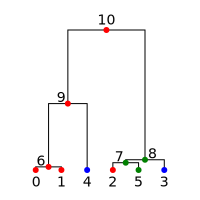

In [247]:
pop_configs = [msprime.PopulationConfiguration(sample_size=3),
               msprime.PopulationConfiguration(sample_size=2),
               msprime.PopulationConfiguration(sample_size=1)]
migration_matrix = [[0, 0.1, 1],
                    [1, 0, 1],
                    [2, 0.3, 0]]
ts = msprime.simulate(
population_configurations=pop_configs, migration_matrix=migration_matrix,
record_migrations=True)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
print(tree)
print(msprime_to_masco(tree))
SVG(tree.draw(node_colours=node_colours))


In [297]:
def MASCO2():
    #for s, m_span in enumerate(np.linspace(0.01, 2, 100)):
        # M is the overall symmetric migration rate, and d is the number
        # of demes.
        # We rescale m into per-generation values for msprime.
        # Allocate the initial sample. Because we are interested in the
        # between deme coalescence times, we choose one sample each
        # from the first two demes.
    ins = 10000
    population_configurations = [
    msprime.PopulationConfiguration(sample_size=2, initial_size=10000),
    msprime.PopulationConfiguration(sample_size=1, initial_size=10000)]
        # Now we set up the migration matrix. Since this is a symmetric
        # island model, we have the same rate of migration between all
        # pairs of demes. Diagonal elements must be zero.
    migration_matrix1 = [[0, 0.000025],
                         [0.000025, 0]]
    migration_matrix2 = [[0, 0.5],
                         [0.5, 0]]
        # We pass these values to the simulate function, and ask it
        # to run the required number of replicates.
        #migration_matrix=migration_matrix,
    num_replicates = 100
    replicates = msprime.simulate(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix1,
        num_replicates=num_replicates, Ne = 1)
        # And then iterate over these replicates
    P1 = np.zeros(num_replicates)
    P2 = np.zeros(num_replicates)
    for i, tree_sequence in enumerate(replicates):
        tree = next(tree_sequence.trees())
        lineage_list, limits_list = msprime_to_masco(tree)[0], np.array(msprime_to_masco(tree)[1]) / 20000
        # Convert the TMRCA to coalecent units.
        tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
        P2[i] = prop_2(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
        tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
        P1[i] = prop_1(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
            #print(lineage_list, limits_list)
    D1 = np.prod(P1)
    D2 = np.prod(P2)
        #Q1 = D1 / np.sum(D1)
        #Q2 = D2 / np.sum(D2)
        #Res1 = (1 / num_replicates) * np.sum()
        # Finally, calculate the analytical expectation and print
        # out the results
        #print("Observed  =", np.mean(T))
    print("Masco1 =", D1, "Masco2 =", D2)
        #print("Masco2 =", P1, P2)
    #print(np.array(D1).shape, np.array(D2).shape, m_span.shape)
    
    #return(D1, D2, m_span)

    
def graph(P1, P2, m):
    x = np.log(np.array(P1) / np.array(P2))
    fig, ax = plt.subplots()

    ax.plot(m, P1, color="red")
    ax.grid()

    ax.plot(m, P2, color="blue")
    ax.grid()
    
    ax.set_xlabel("number of populations")
    ax.set_ylabel("TMRCA")

    plt.show()

In [299]:
MASCO2()

Masco1 = 1.32805611698448e-152 Masco2 = 1.729580177073188e-145


In [330]:
def system_of_DE_for_lines_2(data: Tree, p2: np.ndarray) -> np.ndarray:
    """
    :param data: 
    :param p: p means P(L_i = l_i , L_j = l_j, T)  0.5 * n * (n-1) * m^2 length matrix 
    :return: (result) derivative of probability function for each line in any population,
             1-D array with length = m * n
    """
    result = [[] for i in range(data.number_of_populations ** 2)]
    value_of_cur_fun = 0
    # по каждой популяции
    n = data.cur_samples_amount
    #print(n)
    p2 = np.reshape(p2, (data.number_of_populations ** 2, -1))
    #print(p2)
    for pop1 in range(data.number_of_populations):
        for pop2 in range(data.number_of_populations):
            # по всем образцам
            for i in range(data.cur_samples_amount):
                for j in range(data.cur_samples_amount):
                    if i < j:
                # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
                ################################################
                # первое(1-я часть семмы) слагаемое
                        for a in range(data.number_of_populations):    
                            value_of_cur_fun += data.migration_probability[a][pop1] * p2[a * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] 

                            value_of_cur_fun += data.migration_probability[a][pop2] * p2[pop1 * data.number_of_populations + a, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                            value_of_cur_fun -= (data.migration_probability[pop1][a] + data.migration_probability[pop2][a]) * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                    ################################################
                    # первое(2-я часть суммы) слагаемое
                    ################################################
                    # второе слагаемое
                        for a in range(data.number_of_populations):
                            sum_of_mult = 0
                            for s in range(data.cur_samples_amount):
                                if (s != i) and (s != j):
                                    for k in range(data.cur_samples_amount):
                                        if (k != i) and (k != j) and (k != s) and (s < k):
                                            t_sum = 0
                                            for l in range(data.number_of_populations):
                                                for q in range(data.number_of_populations):
                                                    t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-s-1)*(n-s)/2 + k - s - 1)]

                                            sum_of_mult += p2[a * data.number_of_populations + a, int(n*(n-1)/2 - (n-s-1)*(n-s)/2 + k - s - 1)]/t_sum

                            
                            value_of_cur_fun -= sum_of_mult * data.coalescence_probability[a] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                            #print(value_of_cur_fun, 0, i, j)
                        ############################################
                        # третье слагаемое
                        for k in range(data.cur_samples_amount):
                            if (k < i):
                                t_sum = 0
                                t_sum1 = 0
                                t_sum2 = 0
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        #print(k, i, j)
                                        t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)]
                                        t_sum1 += p2[pop1 * data.number_of_populations + q, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + i - k - 1)]
                                        t_sum2 += p2[pop2 * data.number_of_populations + l, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]
                                value_of_cur_fun -= p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))
                                #print(value_of_cur_fun, 1, i, j)
                            elif i < k < j:
                                #print(k, i, j)
                                t_sum = 0
                                t_sum1 = 0
                                t_sum2 = 0
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        t_sum += p2[l * data.number_of_populations + q,  int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum1 += p2[pop1 * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum2 += p2[l * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-k-1)*(n-k)/2 + j - k - 1)]
                                value_of_cur_fun -= p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))
                                #print(value_of_cur_fun, 2, i, j)
                            elif ( k > j):
                                #print(k, i, j)
                                t_sum = 0
                                t_sum1 = 0
                                t_sum2 = 0
                                for l in range(data.number_of_populations):
                                    for q in range(data.number_of_populations):
                                        t_sum += p2[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum1 += p2[l * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + k - i - 1)]
                                        t_sum2 += p2[q * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-j-1)*(n-j)/2 + k - j - 1)]
                                value_of_cur_fun -= p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * ((t_sum1 * data.coalescence_probability[pop1] / t_sum) + (t_sum2 * data.coalescence_probability[pop2] / t_sum))
                                #print(value_of_cur_fun, 3, i, j)
                        ################################################
                        ################################################
                        if pop1 == pop2:
                            value_of_cur_fun -= data.coalescence_probability[pop1] * p2[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)]
                        #print(value_of_cur_fun, 4, i, j)

                        result[pop1 * data.number_of_populations + pop2].append(value_of_cur_fun)
                        value_of_cur_fun = 0
                        #print(result)
            
    result = np.reshape(result, (1, -1))[0]

    return result



def create_initial(data: Tree,
                   period: int,
                   previous_states: np.ndarray = None,
                   lineage: np.ndarray = None) -> np.ndarray:
    """
    :param data:
    :param period:
    :param previous_states: probabilities before coalescence
    :param lineage: contains two samples that participated in coalescence
    :return: result: vector of initial states for current "period"
    """
    #data.number_of_samples
    # *** обращение к нужному p через индекс ( pop * data.cur_samples_amount + i )
    n = data.cur_samples_amount
    if period == 0:
        result = [[] for i in range(data.number_of_populations ** 2)]
        for i in range(data.number_of_populations):
            for j in range(data.number_of_populations):
                a1 = data.number_of_samples[i]
                a2 = data.number_of_samples[j]
                n1 = np.sum(data.number_of_samples[:i])
                n2 = np.sum(data.number_of_samples[:j])
                for k in range(data.samples_amount):
                    for l in range(data.samples_amount):
                        if k < l:
                            if (n1 - 1 < k < n1 + a1) and (n2 - 1 < l < n2 + a2):
                                result[data.number_of_populations * i + j].append(1)
                            else:
                                result[data.number_of_populations * i + j].append(0)
        result = result = np.reshape(result, (1, -1))[0]
        return(result)
    else:
        previous_states = np.reshape(previous_states, ( data.number_of_populations ** 2, -1))
        lineage = np.sort(lineage)
        result = [[] for i in range(data.number_of_populations ** 2)]
        # cur_samples_sum = 0  ??нужно??

        # посчитаю все условные вероятности для lineage[0] и всех 'pop'
        conditional_prob = []
        t_sum0 = 0
        for l in range(data.number_of_populations):
            for q in range(data.number_of_populations):
                #print(n, lineage[0], lineage[1])
                #print(int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1))
                t_sum0 += previous_states[l * data.number_of_populations + q, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]
        for pop in range(data.number_of_populations):
            conditional_prob.append((previous_states[pop * data.number_of_populations + pop, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)]) * data.coalescence_probability[pop])
        sum_conditional_prob = np.sum(conditional_prob)  # ??? нужно ли переводить в массив ???
        #print(sum_conditional_prob, t_sum0)
        # по каждой популяции
        for pop1 in range(data.number_of_populations):
            for pop2 in range(data.number_of_populations):
                # по каждому образцу
                for i in range(data.cur_samples_amount -1):
                    for j in range(data.cur_samples_amount - 1):
                        if i < j:
                            t_sum1 = 0
                            if lineage[0] < i:
                                if lineage[1] < i:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-2)*(n-i-1)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] == i:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-2)*(n-i-1)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                                elif i < lineage[1] < j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] == j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] > j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                            elif lineage[0] == i:
                                if lineage[1] < j:
                                    for s in range(data.number_of_populations):
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                    result[pop1 * data.number_of_populations + pop2].append(t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop2])
                                elif lineage[1] == j:
                                    for s in range(data.number_of_populations):
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i)]
                                    result[pop1 * data.number_of_populations + pop2].append(t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop2])
                                elif lineage[1] > j:
                                    for s in range(data.number_of_populations):
                                        t_sum1 += previous_states[s * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                    result[pop1 * data.number_of_populations + pop2].append(t_sum1 * previous_states[pop1 * data.number_of_populations + pop1, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop2])
                            elif i < lineage[0] < j:
                                if lineage[1] <= j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i)] * sum_conditional_prob / t_sum0)
                                elif lineage[1] > j:
                                    result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
                            elif lineage[0] == j:
                                for s in range(data.number_of_populations):
                                    t_sum1 += previous_states[pop1 * data.number_of_populations + s, int(n*(n-1)/2 - (n-i)*(n-i-1)/2 + j - i - 1)]
                                result[pop1 * data.number_of_populations + pop2].append(t_sum1 * previous_states[pop2 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-lineage[0]-1)*(n-lineage[0])/2 + lineage[1] - lineage[0] - 1)] / t_sum0 * data.coalescence_probability[pop2])
                            elif lineage[0] > j:
                                result[pop1 * data.number_of_populations + pop2].append(previous_states[pop1 * data.number_of_populations + pop2, int(n*(n-1)/2 - (n-i-1)*(n-i)/2 + j - i - 1)] * sum_conditional_prob / t_sum0)
        result = np.reshape(result, (1, -1))[0]
        result2 = np.reshape(result, (data.number_of_populations ** 2, -1))
        data.cur_samples_amount += -1
        return result

In [328]:
def MASCO1():
    Q1 = []
    Q2 = []
    for s, m_span in enumerate(np.linspace(0.001, 2, 100)):
            # M is the overall symmetric migration rate, and d is the number
            # of demes.
            # We rescale m into per-generation values for msprime.
            # Allocate the initial sample. Because we are interested in the
            # between deme coalescence times, we choose one sample each
            # from the first two demes.
        ins = 10000
        population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=10000),
        msprime.PopulationConfiguration(sample_size=1, initial_size=10000)]
            # Now we set up the migration matrix. Since this is a symmetric
            # island model, we have the same rate of migration between all
            # pairs of demes. Diagonal elements must be zero.
        m = m_span / 20000
        migration_matrix1 = [[0, m],
                             [m, 0]]
        migration_matrix2 = [[0, m_span],
                             [m_span, 0]]
            # We pass these values to the simulate function, and ask it
            # to run the required number of replicates.
            #migration_matrix=migration_matrix,
        num_replicates = 1000
        replicates = msprime.simulate(
            population_configurations=population_configurations,
            migration_matrix=migration_matrix1,
            num_replicates=num_replicates, Ne = 1)
            # And then iterate over these replicates
        P1 = np.zeros(num_replicates)
        P2 = np.zeros(num_replicates)
        for i, tree_sequence in enumerate(replicates):
            tree = next(tree_sequence.trees())
            lineage_list, limits_list = msprime_to_masco(tree)[0], np.array(msprime_to_masco(tree)[1]) / 20000
            # Convert the TMRCA to coalecent units.
            tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
            P2[i] = prop_2(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
            tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
            P1[i] = prop_1(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
                #print(lineage_list, limits_list)
        D1 = np.sum(np.log(P1))
        D2 = np.sum(np.log(P2))
        Q1.append(D1)
        Q2.append(D2)
            #Res1 = (1 / num_repnlicates) * np.sum()
            # Finally, calculate the analytical expectation and print
            # out the results
            #print("Observed  =", np.mean(T))
        print("Masco1 =", D1, "Masco2 =", D2, "migrarion_coef =", m_span)
            #print("Masco2 =", P1, P2)
        #print(np.array(D1).shape, np.array(D2).shape, m_span.shape)
    m_span = np.linspace(0.001, 2, 100)
    return(Q1, Q2, m_span)

    
def graph(P1, P2, m):
    x = np.array(P1) / np.array(P2)
    fig, ax = plt.subplots()

    ax.plot(m, x, color="red")
    ax.grid()

    #ax.plot(m, P2, color="blue")
    #ax.grid()
    
    ax.set_xlabel("migration_coef")
    ax.set_ylabel("Prob")

    plt.show()
    

Masco1 = -8233.96737364879 Masco2 = -8237.985321359398 migrarion_coef = 0.001
Masco1 = -5196.76078001128 Masco2 = -5222.811092461177 migrarion_coef = 0.021191919191919192
Masco1 = -4591.760703618245 Masco2 = -4621.104823487905 migrarion_coef = 0.041383838383838384
Masco1 = -4266.681498467959 Masco2 = -4309.491772307617 migrarion_coef = 0.061575757575757575
Masco1 = -4174.678436733511 Masco2 = -4207.577227244652 migrarion_coef = 0.08176767676767677
Masco1 = -3986.065304492115 Masco2 = -4028.259596713759 migrarion_coef = 0.10195959595959596
Masco1 = -3827.9610458372417 Masco2 = -3860.9255967479658 migrarion_coef = 0.12215151515151515
Masco1 = -3783.2182326682537 Masco2 = -3796.787875593444 migrarion_coef = 0.14234343434343433
Masco1 = -3662.734584103444 Masco2 = -3675.790623558003 migrarion_coef = 0.16253535353535353
Masco1 = -3621.9398418129686 Masco2 = -3627.9782807834818 migrarion_coef = 0.18272727272727274
Masco1 = -3616.058994592381 Masco2 = -3600.9733896551716 migrarion_coef = 0.20

C:\anaconda\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
C:\anaconda\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Masco1 = nan Masco2 = -3491.1382966331093 migrarion_coef = 0.2433030303030303
Masco1 = nan Masco2 = -3518.51827457622 migrarion_coef = 0.2634949494949495
Masco1 = -3537.7860444025728 Masco2 = -3487.471215826845 migrarion_coef = 0.28368686868686865
Masco1 = -3469.3448168422497 Masco2 = -3410.7500712698406 migrarion_coef = 0.30387878787878786
Masco1 = -3554.646686030019 Masco2 = -3467.119246820319 migrarion_coef = 0.32407070707070706
Masco1 = -3331.995222692661 Masco2 = -3286.904045686828 migrarion_coef = 0.34426262626262627
Masco1 = nan Masco2 = -3381.768825527225 migrarion_coef = 0.3644545454545455
Masco1 = nan Masco2 = -3348.1569812088715 migrarion_coef = 0.3846464646464646
Masco1 = -3451.3954171794076 Masco2 = -3351.760816083057 migrarion_coef = 0.40483838383838383
Masco1 = nan Masco2 = -3282.1648675112374 migrarion_coef = 0.42503030303030304
Masco1 = -3461.0277933531265 Masco2 = -3341.338419616558 migrarion_coef = 0.4452222222222222
Masco1 = -3486.402462739571 Masco2 = -3365.3755333

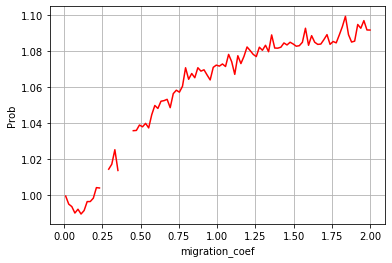

In [329]:
Q1, Q2, m_span = MASCO1()
graph(Q1, Q2, m)

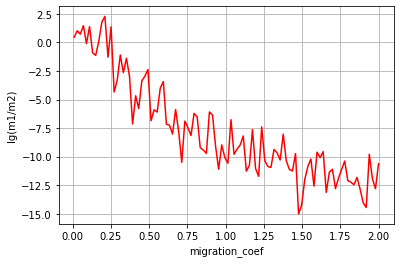

In [317]:
def graph(P1, P2, m):
    x = np.log10(np.array(P1) / np.array(P2))
    fig, ax = plt.subplots()

    ax.plot(m, x, color="red")
    ax.grid()

    #ax.plot(m, P2, color="blue")
    #ax.grid()
    
    ax.set_xlabel("migration_coef")
    ax.set_ylabel("lg(m1/m2)")

    plt.show()
    
graph(Q1, Q2, m)

In [333]:
def graph(P1, P2, m):
    w = np.where(P1)
    x = np.array(P1) / np.array(P2)
    fig, ax = plt.subplots()

    ax.plot(m, x, color="red")
    ax.grid()

    #ax.plot(m, P2, color="blue")
    #ax.grid()
    
    ax.set_xlabel("migration_coef")
    ax.set_ylabel("Prob")

    plt.show()
    
def MASCO1():
    Q1 = []
    Q2 = []
    for s, m_span in enumerate(np.linspace(0.01, 2, 100)):
            # M is the overall symmetric migration rate, and d is the number
            # of demes.
            # We rescale m into per-generation values for msprime.
            # Allocate the initial sample. Because we are interested in the
            # between deme coalescence times, we choose one sample each
            # from the first two demes.
        ins = 10000
        population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=10000),
        msprime.PopulationConfiguration(sample_size=1, initial_size=10000)]
            # Now we set up the migration matrix. Since this is a symmetric
            # island model, we have the same rate of migration between all
            # pairs of demes. Diagonal elements must be zero.
        m = m_span / 20000
        migration_matrix1 = [[0, m],
                             [m, 0]]
        migration_matrix2 = [[0, m_span],
                             [m_span, 0]]
            # We pass these values to the simulate function, and ask it
            # to run the required number of replicates.
            #migration_matrix=migration_matrix,
        num_replicates = 100
        replicates = msprime.simulate(
            population_configurations=population_configurations,
            migration_matrix=migration_matrix1,
            num_replicates=num_replicates, Ne = 1)
            # And then iterate over these replicates
        P1 = np.zeros(num_replicates)
        P2 = np.zeros(num_replicates)
        for i, tree_sequence in enumerate(replicates):
            tree = next(tree_sequence.trees())
            lineage_list, limits_list = msprime_to_masco(tree)[0], np.array(msprime_to_masco(tree)[1]) / 20000
            # Convert the TMRCA to coalecent units.
            tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
            P2[i] = prop_2(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
            tree_1 = Tree(migration_rates = migration_matrix2, number_of_samples = [2, 1], number_of_populations = 2, coalescence_rates = [1, 1], coalescence_time = 1000000, Q = 1, N = 1000)
            P1[i] = prop_1(limits_list = limits_list, lineage_list = lineage_list, tree = tree_1)
                #print(lineage_list, limits_list)
        D1 = np.sum(np.log(P1))
        D2 = np.sum(np.log(P2))
        Q1.append(D1)
        Q2.append(D2)
            #Res1 = (1 / num_repnlicates) * np.sum()
            # Finally, calculate the analytical expectation and print
            # out the results
            #print("Observed  =", np.mean(T))
        print("Masco1 =", D1, "Masco2 =", D2, "migrarion_coef =", m_span)
            #print("Masco2 =", P1, P2)
        #print(np.array(D1).shape, np.array(D2).shape, m_span.shape)
    m_span = np.linspace(0.01, 2, 100)
    return(Q1, Q2, m_span)


In [334]:
Q1, Q2, m_span = MASCO1()
graph(Q1, Q2, m)

Masco1 = -585.5787470554786 Masco2 = -777.871982372333 migrarion_coef = 0.01


C:\anaconda\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 